# Machine learning and Data Science for Social Good: Final assignment

This notebook presents the assignment for the course *Machine learning and data science for social good*. The objective is to investigate a dataset for bias using a specific use case context and to identify possible solutions to reduce the bias to achieve a fairer result. 

<font color='grey'>Niklas Jaggy\
Mnr. 12033861 </font>

## Part 1: Dataset and context

The dataset chosen for this assignment is a popular set for machine learing model training and is known as *Census Income* dataset. It contains more than 32.500 entries with information on common census attributes:

- Age
- Workclass
- Final Weight
- Education
- Marital status
- Occupation
- Relationship
- Race
- Sex
- Capital gain
- Capital loss
- hours per week 
- Native Country
- Income (>50K or <=50K)

The prediction task is to determine if a person earns more or less than 50K $ per year. More detailed information on the dataset can be found at the official website of the dataset:

**Data source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult)

Donor:\
Ronny Kohavi and Barry Becker\
Data Mining and Visualization\
Silicon Graphics.\
e-mail: ronnyk@live.com for questions

In the following section, the data is loaded from the official website and some exploration is done to understand the dataset at hand. Afterwards, the case study for this assignment is explained.

In [ ]:
!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [ ]:
adult_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)
adult_data.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
adult_data.head()

In [ ]:
print(adult_data.shape)
print(adult_data.isnull().values.any())

### Data exploration

This section explores the adult dataset to gain insights on how the attributes values are distributed. This allows to discover if some parts of the dataset is skewed or classes are imbalanced, which is a possible source of bias in the data science and machine learning process chain. To get an overview on the data, some of the attributes that are most likely to be investigated for bias in the later steps are displayed using histograms and pie charts.\
The histogram for Age reveals a distribution of values as it would be assumed for the US population starting from the year *17*. However, significant outliers are detected at a regular distance across all age groups. The histogram for Race shows that the most predominant category is *White*, while the remaining categories only constitute minor groups.


In [ ]:
sns.set_style('darkgrid')
sns.histplot(adult_data.Age).set_title("Age histogram")

In [ ]:
sns.set_style('darkgrid')
sns.histplot(adult_data.Race).set_title("Race histogram")

The pie charts of attributes Gender, Race and Edcuation give hints on where the data is skewed. As seen in the histogram above the category *White* is predominant for Race. But Gender is also not balanced but contains over 60% people that are *Male*. For the attribute Education much more values are available and not a single one dominates the rest. Still, more than a quarter is made up by people with a *HS-grad* education degree. 

In [ ]:
x = pd.DataFrame(adult_data["Gender"].value_counts())
plot = x.plot.pie(y="Gender", figsize=(5, 5))

In [ ]:
x = pd.DataFrame(adult_data["Race"].value_counts())
plot = x.plot.pie(y="Race", figsize=(5, 5))

In [ ]:
x = pd.DataFrame(adult_data["Education"].value_counts())
plot = x.plot.pie(y="Education", figsize=(5, 5))

In [ ]:
x = pd.DataFrame(adult_data["Income"].value_counts())
plot = x.plot.pie(y="Income", figsize=(5, 5))

### Case study (fictional):
The **FAIRbank** wants to know if an loan applicant for loans exceeding 200.000\\$ earns more than 50K \\$/year. If this is the case, the applicant is labelled credit worthy and will get his loan granted.

Because the Bank has as its declared objective to provide a fair evaluation process, the model used to label the applicants needs to reflect this fairness. The ultimate goal is to grant all credit worthy applicants a loan and therefore constitutes an <font color='green'>assistive</font> measure.  

As no perfect classifier exists it is necessary to consider beforehand how the predictions affect all parties in the use case, meaning who gains and loses from specific descisions. This consequences of such a scenario were part of a previous assignment as are outlined below.

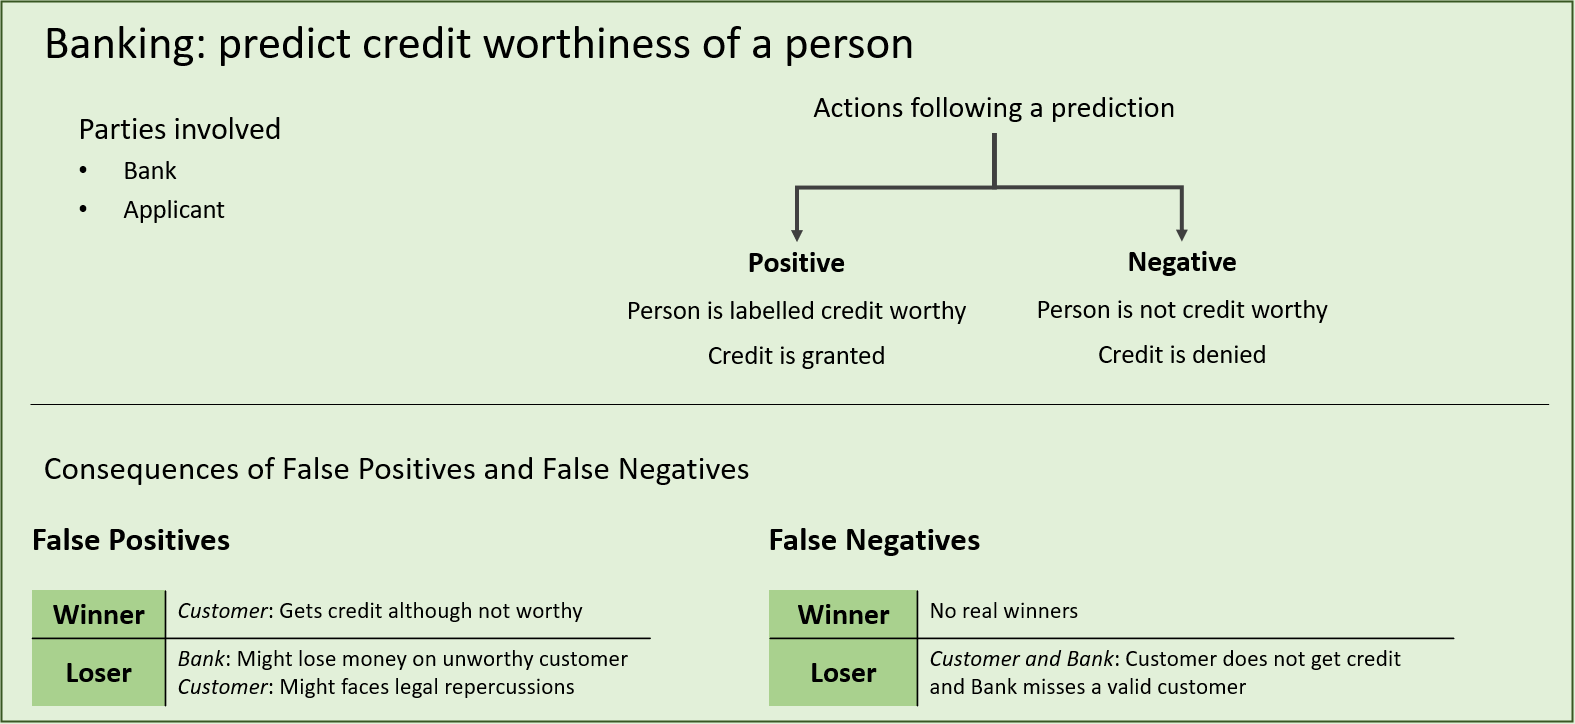

## Part 2: Classification

### Choosing the right model

Before a model can be checked for bias and fairness, first a model needs to be created and applied to the classification task. For this assignment, **RapidMiner Go** was chosen to evaluate which machine learning algorithm is the most suitable for the adult dataset. The choice for the models to be compared was based on the following model overview. As the bank wants to predict numeric values with the highest possible accuracy the choice was made for Random Forest, Gradient Boosting Tree and a Neural Network (Deep Learning). 

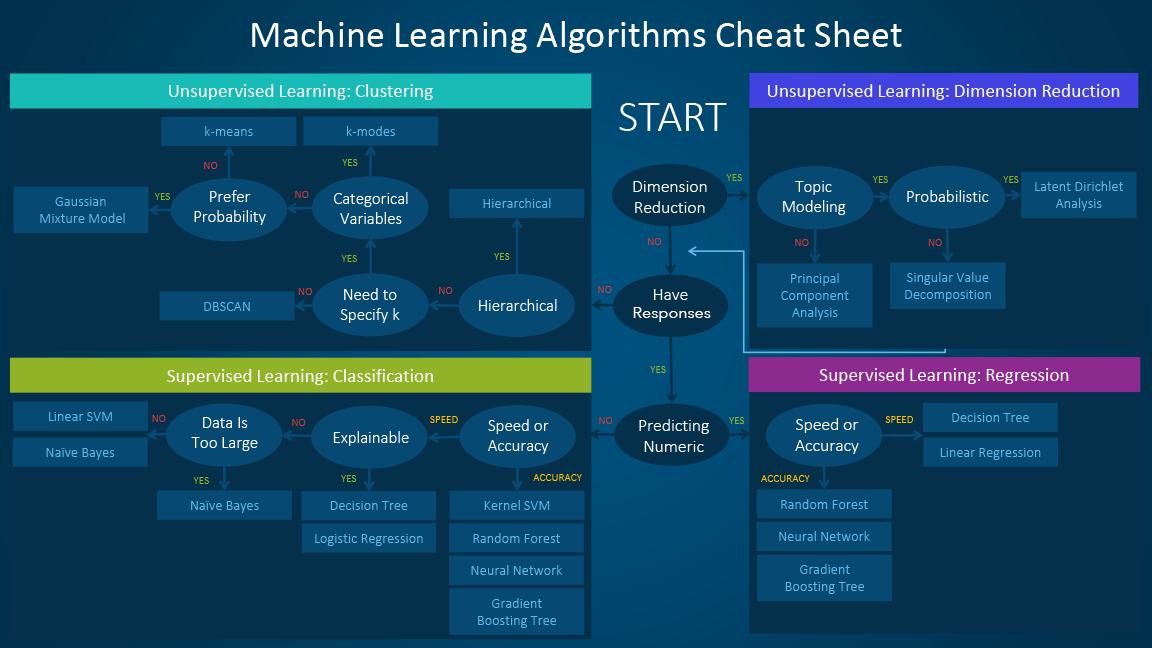

The models were trained on the adult data set to predict wether a person earns >50K or not with emphasize on the accuracy of the ">50K" category based on the case that false negatives and false positives have a higher impact on the involved parties than false predictions in the "<50K" category. The resulting trained models yieled only small differences in overall accuracy and other accuracy metrics (precision, recall, AUC).

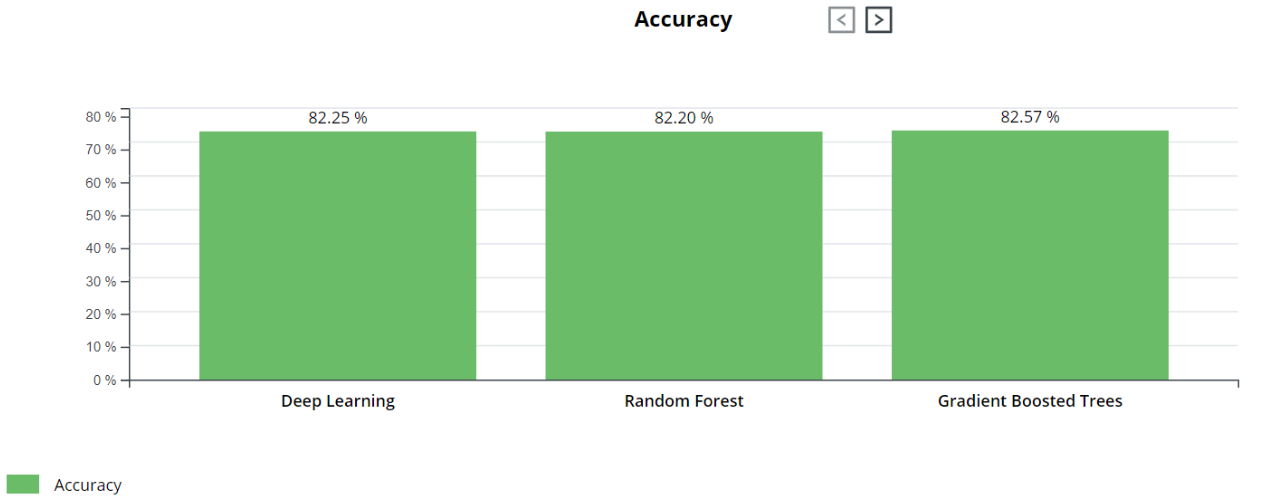

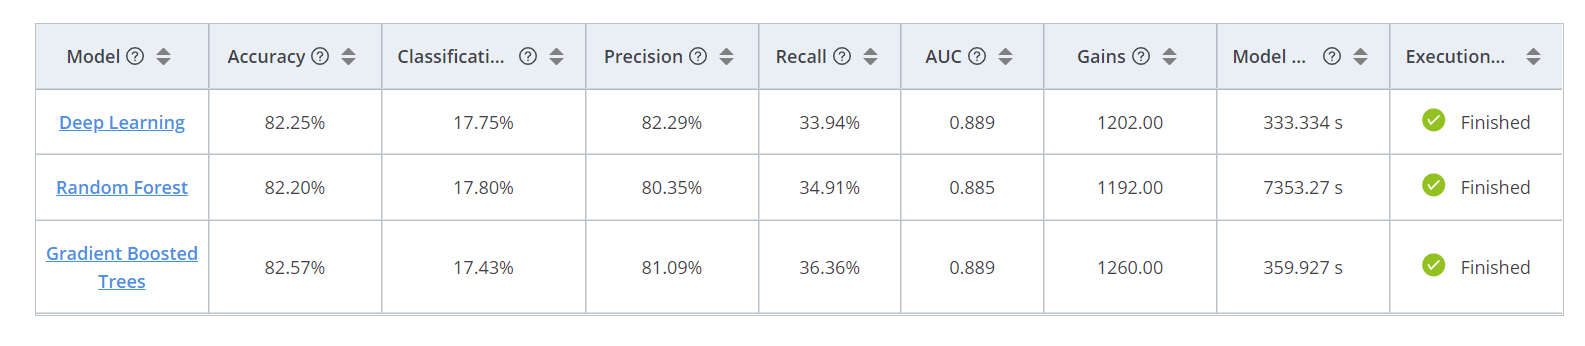

The overview over the accuracy metrics shows that the **Gradient Boosted Trees** model performs best. Therefore it is used for the prediction of yearly income for our dataset.

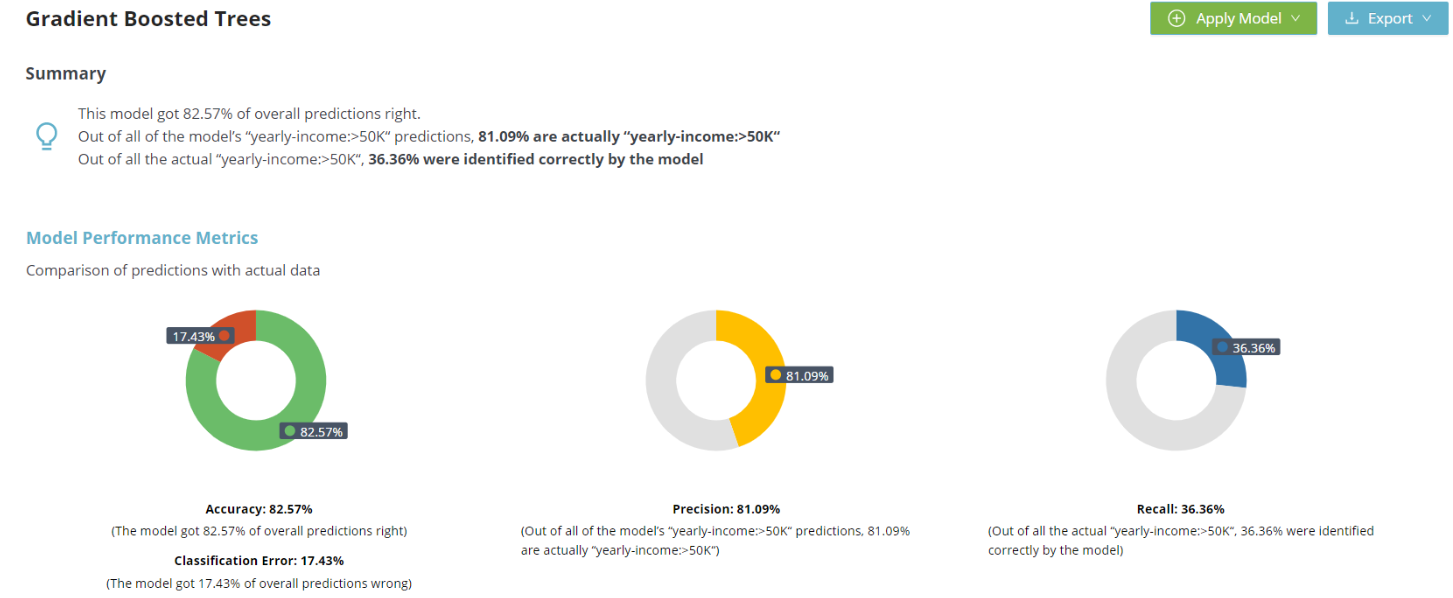

The model achieves an overall **accuracy** and **precision** of satisfying 82.5% and 81.09%. Unfortunately, the **recall** is fairly low with only 36.36%, meaning the share of real positives the model predicts is only a little bit higher than 1 out of 3.

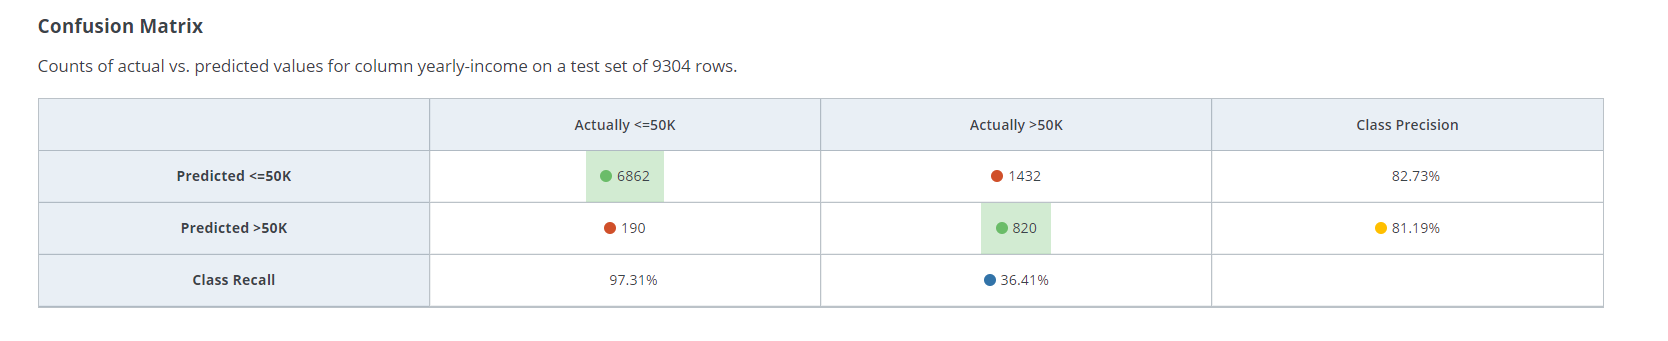

The ROC (Receiver Operating Characterstic) shows that our model still compares quite good compared to a no-skill classifier (diagonal line). 

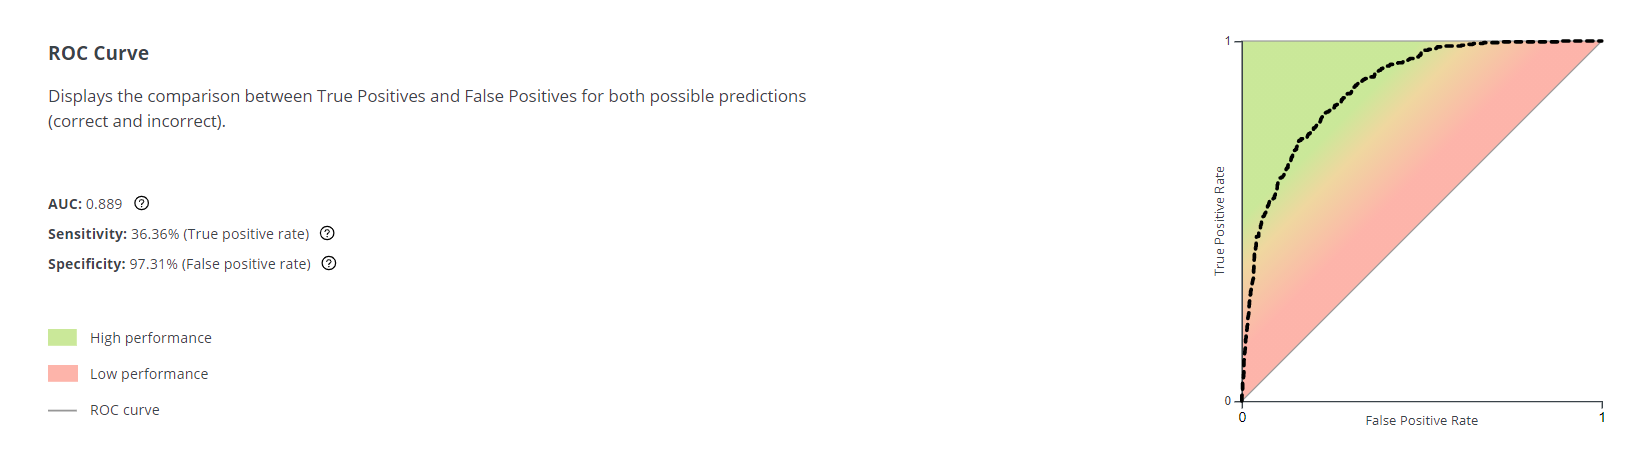

When looking on how the individual attributes influence the classifier it is revealed that the most important attributes are Education, Relationship, Marital status and Race. As the exploratory data analysis showed, Education is to a certain degree imbalanced, while Race is largely imbalanced. Combined with the high influence on the classificator, these attributes need to be included when investigating the model for bias.

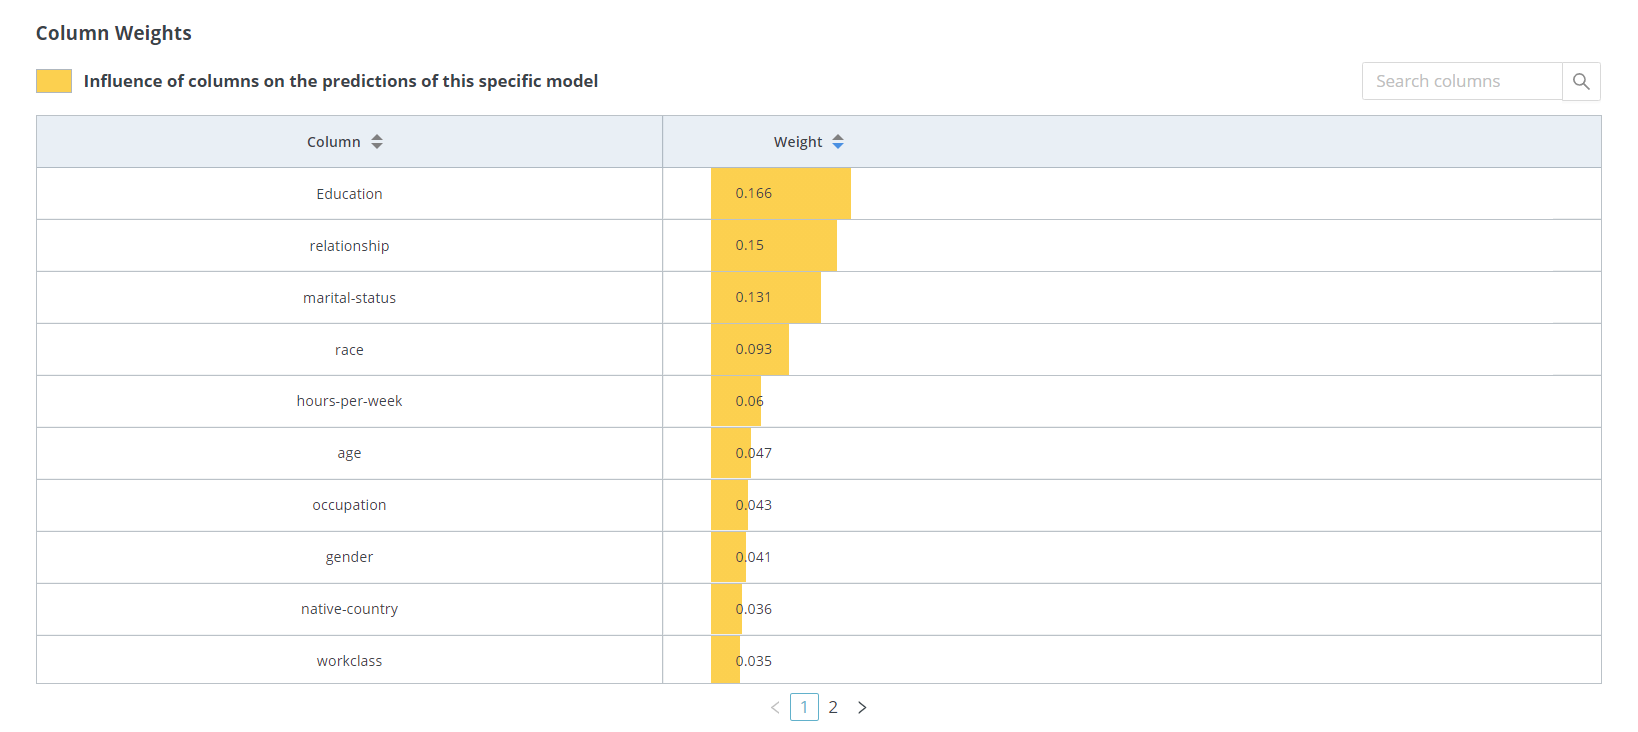

## Part 3: Aequitas bias audit

This section includes the entire process of auditing the classification model for bias using the [Aequitas](http://aequitas.dssg.io/) toolkit. The open-source toolkit was developed to audit ML models for bias and discrimination in order to understand if and what types of biases are present in a model. This allows a transparent developing and deploying of ML tools that are able to provide fairer results.

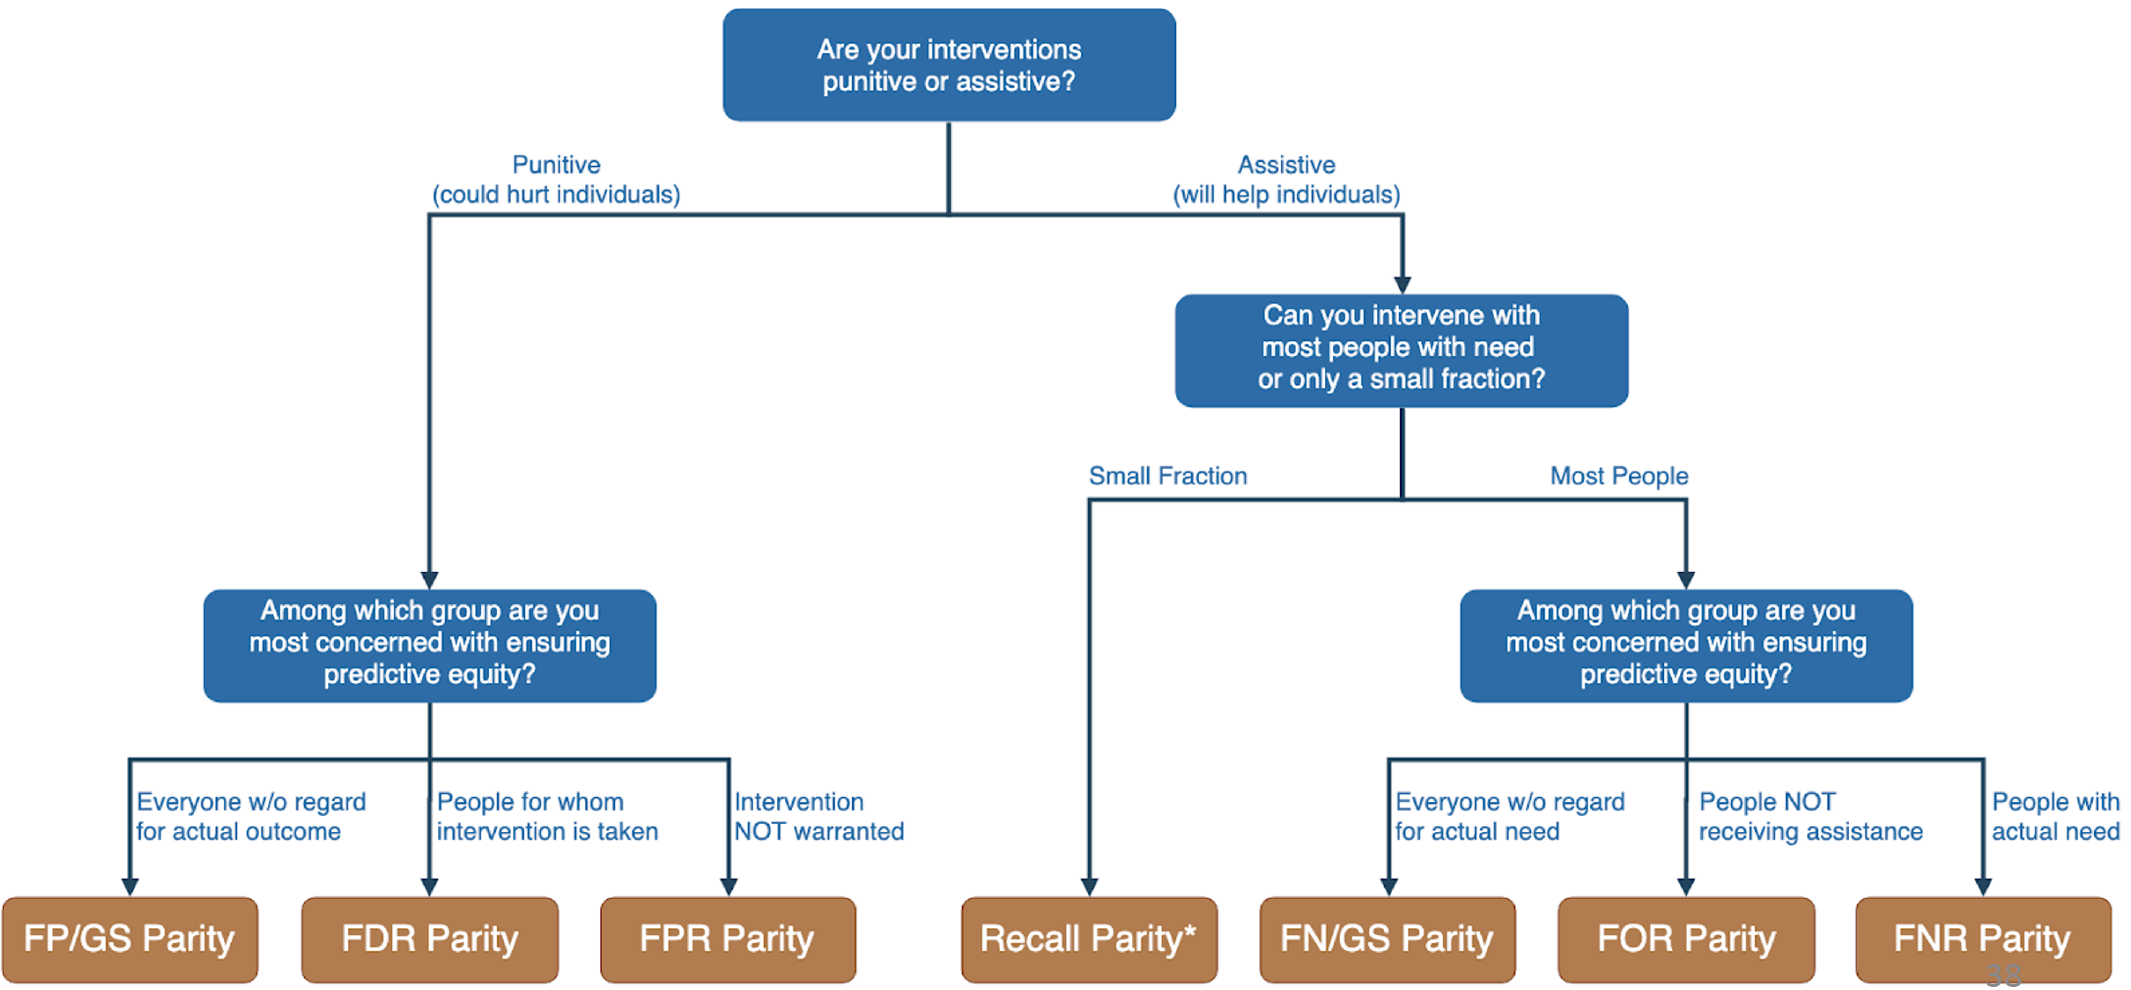

In this case study, the bank is interested to fairly determine the people with actual need that are credit worthy. As the granting of loans is an **assistive** measure and the focus is on people with actual need for which we want to ensure predictive equity, **FNR Partiy** is the most important metric for our analysis. The second important metric is the **Recall Parity**, because we want granting of loans to credit worthy people to be distributed in a representative way.

The first step is to prepare the classifier output to match the requirements of the Aequitas tool. This requires a column named *Label_value* that contains the ground truth data and a second column *Score* that holds the predictions. The labelling was done manually before the file was uploaded and then directly accessed from this notebook.

In [ ]:
prediction_data = pd.read_csv("https://cfd1e30b-0883-46cc-aa24-b895a089c3b2.filesusr.com/ugd/fba136_b80e8ff12b684ade8ec816084c90f42a.csv?dn=prediction_result_adjusted2.csv")
prediction_data.isnull().values.any()

**Exploring the classification result**

Before the model is investigated on any bias, an explorative step is prepended to gain an overview on how the predictions compare to the ground truth data. As explained above, the focus is set on the attributes Gender, Race and Relationship.

In [ ]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

aq_palette = sns.diverging_palette(225, 35, n=2)
plt.rcParams['figure.figsize'] = [12, 8]

In [ ]:
# to see the results for predictions according to gender: 
fig, ax = plt.subplots(1,2)

pred_by_race = sns.countplot(x="gender", hue="Score", data=prediction_data[prediction_data.gender.isin(['Female', 'Male'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Gender')

truth_by_race = sns.countplot(x="gender", hue="Label_value", data=prediction_data[prediction_data.gender.isin(['Female', 'Male'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Gender')

When looking at *Gender*, it appears that the model tends to overestimate the amount of *Male* persons earning >50K. The same happens for *Female* persons but to a far smaller extent then for *Male*. Therefore, a first bias might be detected.

In [ ]:
# to see the results for predictions according to race: 

fig, ax = plt.subplots(1,2)

pred_by_race = sns.countplot(x="race", hue="Score", data=prediction_data[prediction_data.race.isin(['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Black'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Race')

truth_by_race = sns.countplot(x="race", hue="Label_value", data=prediction_data[prediction_data.race.isin(['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Black'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Race')

For *Race* a similar pattern is visible as for all races the amount of people with yearly earnings >50K is overpredicted. But the largest discrepancy is found for *White* people where a predicted third is a high-earnern while actually only 1 out of 6 earnes larger 50K.

In [ ]:
# to see the results for predictions according to relationship: 

fig, ax = plt.subplots(1,2)

pred_by_race = sns.countplot(x="relationship", hue="Score", data=prediction_data[prediction_data.relationship.isin(['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Relationship')

truth_by_race = sns.countplot(x="relationship", hue="Label_value", data=prediction_data[prediction_data.relationship.isin(['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Relationhsip')

Unsurprisingly the effects are also visible for *Relationship*. While generally overestimation is found for all attribute values, the dominant ones for this attribute are *Husband* and *Wife relationship*.

The exploration showed that while overprediction is visible for all attributes, the model tends to favor people that are *Male*, *White* and *Husband* or *Wife relationship*. This means that if the FAIRbank would apply this model to evaluate if an applicant is credit worthy, people of the type just mentioned would be highly privileged and would get their loans easier granted. Because the bank wants everyone to be evaluated in a fair way, the exact patterns in the model need to be determined in order to improve the results.

### Applying Aequitas

The programmaticaly application of the Aequitas toolkit us procedureal process that uses 3 python classes:

1. Group() -> Defines groups
2. Bias() -> Calculates disparities
3. Fairness() -> Asserts fairness

Each class thereby builts on the output DataFrame from the previous class.

**Data preparation**

Before any class can be applied some formatting is needed to be conform with the requirements of Aequitas. This means relabelling the **Score** and **Label_value** columns to **score** and **label_value** and converting the values from **<=50K** and **>50K** to **0** and **1**. Additionally, the following format of the input table is needed: **score, label_value, attribute1, attribute2, ...**. 
For this analysis, the attributes *Gender*, *Race* and *Relationship* were included.

In [ ]:
prediction_data["score"] = prediction_data["Score"]
prediction_data["label_value"] = prediction_data["Label_value"]
prediction_data["label_value"] = prediction_data["label_value"].map({ "<=50K": 0, ">50K": 1 })
prediction_data["score"] = prediction_data["score"].map({ "<=50K": 0, ">50K": 1 })

prediction_data.head()

In [ ]:
prediction_format = pd.DataFrame()
prediction_format = prediction_data[["score", "label_value", "gender", "race", "relationship"]]
prediction_format = prediction_format.dropna(how='any', axis=0)

print(prediction_format.isnull().values.any())

### Group() class

The Group() class is used to create confusion matrices for each subgroup (e.g. Gender - Female), the respective counts (e.g. TruePositive Count) and calculating common metrics such as the FDR (false discovery rate) or the precision.

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(prediction_format)

In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)

View calculated counts across sample population groups

In [ ]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

View calculated absolute metrics for each sample population group

In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

Results show disparities in TPR (recall) within each subgroups of all attributes. This means, for example, that *Male* persons are roughly 20% more likely to be labelled credit worhty that women. Same is true for people with race *White* and *Asian_pac_Islander* compared the the remaining races. 

**Level of disparity between groups**

After the metrics for the groups are calculated, the Bias() class returns the disparities between groups. These are calculated as ratios using a base group for each attribute which is chosen by the user.\
Using the information from the exploratory section above, the reference groups are set to:
- Race: White
- Gender: Male
- Relationship: Husband

In [ ]:
b = Bias()

In [ ]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=prediction_format, 
                                        ref_groups_dict={'race':'White', 'gender':'Male', 'relationship':'Husband'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

In [ ]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

In [ ]:
metrics = ['fnr','tpr']
disparity_tolerance = 1.25

### Visualizations

As outlined above, the metrics relevant for this case study is the FNR and the TPR (= Recall). The check for disparities is therefore based on these metrics using a disparity tolerance of 1.25.

In [ ]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

The graphic summary reveals that our model fails in terms of fairness for most of the attributes for both metrics. In the following, each attribute is investigated individually.

**Check for disparities in Gender**

The graphic reveals that female loan applicants are 1.62 times less often recognized as such compared to male applicants. Consquently, female applicant are 1.28 times more often misclassified as NOT credit worthy although the opposite is true.

In [ ]:
ap.disparity(bdf, metrics, 'gender', fairness_threshold = disparity_tolerance)

Check how the fairness threshold maps to the absolute values of each metric

In [ ]:
ap.absolute(bdf, metrics, 'gender', fairness_threshold = disparity_tolerance)

**Check for disparities in Race**

Although Asian-Pacific Islanders are even more likely to be identified as valid applicants, the remaining races are significantly disadvantaged.

In [ ]:
ap.disparity(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

Check how the fairness threshold maps to the absolute values of each metric

In [ ]:
ap.absolute(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

**Check for disparities in Relationship**

For Relationship, only *Wife* is withing the tolerance range. Everyone who is *Not in family*, *Unmarried* or  *Other relative* is disadvantaged by the model.

In [ ]:
ap.disparity(bdf, metrics, 'relationship', fairness_threshold = disparity_tolerance)

Check how the fairness threshold maps to the absolute values of each metric

In [ ]:
ap.absolute(bdf, metrics, 'relationship', fairness_threshold = disparity_tolerance)

### Determining fairness

Applying the Fairness() class returns the fairness determinations for each subgroup using the fairness bounds declared above.

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [ ]:
parity_detrminations = f.list_parities(fdf)

In [ ]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

### Attribute level fairness

Here the fairness determinations for each attribute group is determined.

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

### Overall fairness

In [ ]:
gof = f.get_overall_fairness(gaf)
gof

## Part 4: Bias reduction and recommendations

The bias audit has revealed that the model is heavily biased towards people that are *White*, *Male* and a *Husband*. As FAIRbank, however, we want to our prediction tool to provide fair and equitable outcomes. Therefore, the inherent bias needs to be eliminated. As the sources of bias are manifold, each steps needs to be looked at carefully.

#### Bias sources

**The world**\
Because the world is not perfect, a certain bias is already introduced via the real-world circumstance. One of this realities is that women still earn less than their male counterparts, jobwise. Consequently they are less likely to earn >50K per year. The reflection of reality concerning race and the consequences are obviously equally translated into the dataset and therefore into the classifcator. As these sources cannot be changed they need to be dealt with in subsequent steps.

**The data**\
The exploration of data showed that several classes are imbalanced. Particularly the share of *Male* persons is higher than it would be expected when looking at the average population of the US. Similarly, the percentage of *White* people is slightly higher in the dataset than in reality. If not corrected, these biases are directly included in the classifier and prevent fair and unbiased predictions. 

### Reducing bias in ML models

The general workflow of bias reduction in ML models usually consists of the following steps:\
It is described as an iterative process of auditing models for bias and mitigating the respective bias until a model is created that fulfills the fairness criteria.

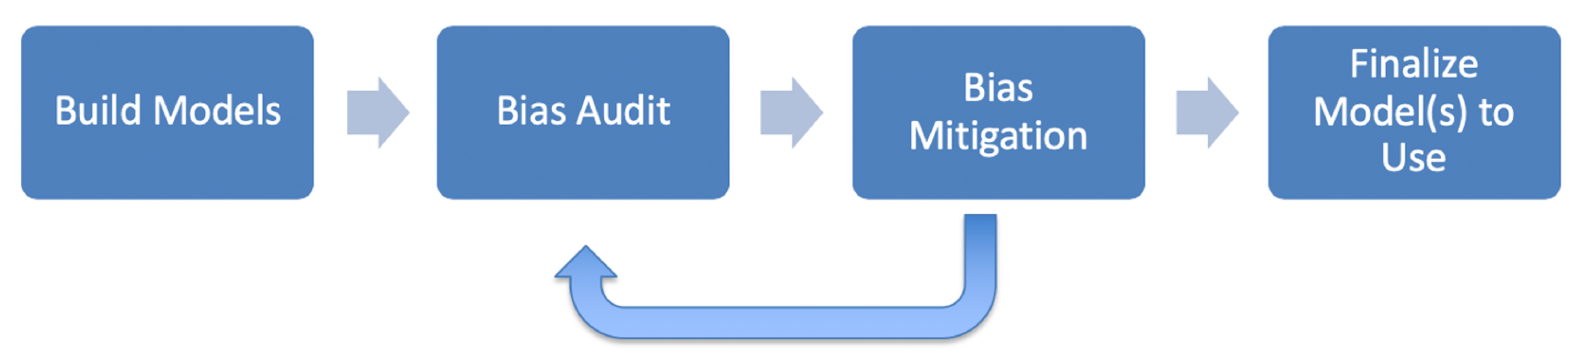

### Recommendations

From the bank´s perspective mitigation strategies are necessary to improve the model fairness before it can be deployed. Several possibilites are described in the following.

**The data**\
The input data for training the model showed class imbalances to a certain degree. These imbalances can be corrected using resampling techniques or by reweighting protected groups. In the case of the adult dataset, escpecially the attributes *Gender* and *Race* should be resampled to a level where each person has the same probabilites of getting a loan, without regard of gender or race. Because the removal of sensitive attributes is proven to be ineffective due to information being encoded in remaining attributes, quite the opposite approach can be taken. Instead of lowering the number of attributes, adding new information with the possibility of explanatory potential might be more valuable. However, these new attributes need to be carefully chosen or at least checked for redundancy with existing attributes.

**The model**\
Concerning the ML model applied to the prediction task, other models should be tested on their fairness, even if the accuracy is lower. Due to a fairness-accuracy tradeoff no perfect solution can be found but the best compromise wins. The bank use case requires a highest possible accuracy and with the Random Forest and Deep Learning models showing only small accuracy differences, a bias audit for them would be appropriate. Again the TPR and FNR are the recommended fairness metrics for this use case to be applied on the other models.

At the point when a model is chosen, it can still be optimized for fairness using methods such as a constrained optimization or a Lagrangian Formulation. A last method are post-hoc adjustments used to de-bias the model scores that are applied to an already learned predictor.